# VAE

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


---


In [2]:
batch_size = 64

dataset = MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

sample_x, _ = next(iter(dataloader))
w, h = sample_x.shape[2:]
image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


In [3]:
@torch.no_grad()
def draw(model, n_images=10, width=800):
    model.eval()
    x, _ = next(iter(dataloader))
    x = x[:n_images].to(device)
    y, _, _, _ = model(x)
    img = torch.cat([x, y], dim=0).cpu()
    img = transforms.Resize((width // n_images), antialias=True)(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)


---


In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        mean, log_var = self.encoder(x).chunk(2, dim=1)
        z = self.representation(mean, log_var)
        y = self.decoder(z).view(-1, 1, 28, 28)
        return y, mean, log_var, z

    def representation(self, mean, log_var):
        norm = torch.randn_like(mean, device=device)
        z = mean + torch.exp(log_var/2)*norm
        return z


---


In [5]:
def loss_fn(x, y, mean, log_var):
    loss_recons = F.binary_cross_entropy(y, x, reduction='sum')
    loss_reg = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
    return loss_recons + loss_reg

def train(model, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.to(device)
            y, mean, log_var, _ = model(x)
            loss = loss_fn(x, y, mean, log_var)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1}epoch loss:{loss.item()}')


---


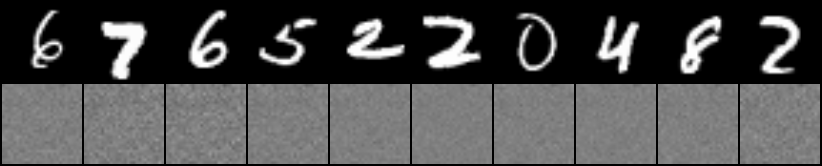

In [6]:
z_dim = 10
vae = VAE(z_dim).to(device)
optimizer = optim.Adam(vae.parameters())
draw(vae)

In [7]:
train(vae, optimizer, 10)

1epoch loss:3752.821533203125
2epoch loss:3835.719970703125
3epoch loss:3324.658935546875
4epoch loss:3497.739013671875
5epoch loss:3432.9052734375
6epoch loss:3251.05078125
7epoch loss:3386.0302734375
8epoch loss:3265.797607421875
9epoch loss:3269.508544921875
10epoch loss:3467.3642578125



---


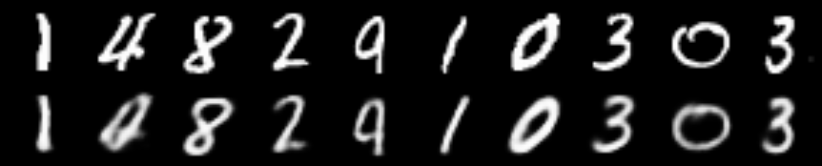

In [8]:
draw(vae)

In [9]:
vae.eval()
latents = []
for x, _ in dataloader:
    x = x.to(device)
    _, _, _, z = vae(x)
    latents.append(z)
latents = torch.cat(latents)
mean = latents.mean().item()
std = latents.std().item()
print(f'mean: {mean:.3f}, std: {std:.3f}')

mean: -0.009, std: 1.013
